In [1]:
from cosim import Flow, Kio

# Setting up custom workflows

* Define **workflows** which are **DAGs of Tasks** that need to be offloaded
* We can define the workflows and tasks using python and use it as **custom modules** for task offloading
* Following example shows how to setup a simple workflow with custom tasks


##### Create Custom Module

* Create a folder `__mods__` which will store all *tasks* as python scripts
* *workflows* are just arrangements of the *tasks* in a DAG

In [2]:
import os
MODSDIR = "__mods__"
os.makedirs(MODSDIR, exist_ok=True)

* Example workflow
    * assume that we have a workflow `T` with 4 tasks `A`, `B`, `C` and `D`.
    * each of this is defined as a python script
    * create the file `__mods__/T.py` and add tasks as functions 
    * task function's output should always be a tuple
    * sample code is shown below

In [3]:
sample_code = """
import time

def A(x):
    time.sleep(2)
    y1 = x*2
    y2 = x-1 
    return (y1, y2)

def B(y1):
    time.sleep(4)
    z1 = y1 - 10
    return (z1, )

def C(y2):
    time.sleep(6)
    z2 = y2 + 10
    return (z2, )

def D(z1, z2):
    time.sleep(2)
    out = z1 + z2
    return (out, )

"""

with open(os.path.join(MODSDIR, "T.py"), 'w') as f: f.write(sample_code)


##### Create Workflows

* After creating the *tasks*, we can represent a workflow using a DAG as described in the following dict object:

In [4]:
info = {
    # first task is entry task - should have only one input
    "T.A": {"inputs": ("x",),           "outputs": ("y1", "y2",),  }, 
    "T.B": {"inputs": ("y1",),          "outputs": ("z1",),        },
    "T.C": {"inputs": ("y2",),          "outputs": ("z2",),        },
    "T.D": {"inputs": ("z2", "z1",),    "outputs": ("out",),       }, 
    # last task is exit task - should have only one output
}

In [5]:
# also save this dict for later use
Kio.SaveJSON('__info__.json', info)

* pass the DAG dict to create a `flow` object

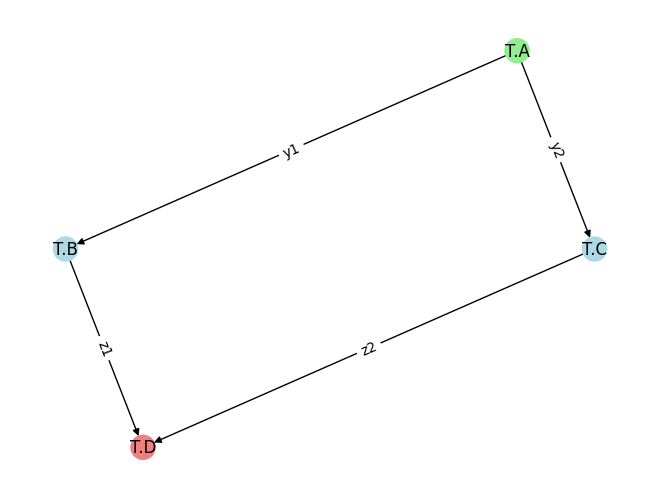

In [6]:
flow = Flow(**info)
flow.render()

* `flow` is inherited from `networkx.DiGraph`
* it has following extra attributes added to it
    * `flow.INFO` - underlying info-dict that was passed while creating flow
    * `flow.NODES` - list of tasks
    * `flow.ENTRY` - first entry task
    * `flow.EXIT` - last exit task
    

In [7]:
flow.INFO

{'T.A': {'inputs': ('x',), 'outputs': ('y1', 'y2')},
 'T.B': {'inputs': ('y1',), 'outputs': ('z1',)},
 'T.C': {'inputs': ('y2',), 'outputs': ('z2',)},
 'T.D': {'inputs': ('z2', 'z1'), 'outputs': ('out',)}}

In [8]:
flow.NODES

['T.A', 'T.B', 'T.C', 'T.D']

In [9]:
flow.ENTRY, flow.EXIT

('T.A', 'T.D')

In [10]:
for n in flow.nodes: print(n, flow.nodes[n])

T.A {'inputs': ('x',), 'outputs': ('y1', 'y2'), 'subset': 0}
T.B {'inputs': ('y1',), 'outputs': ('z1',), 'subset': 1}
T.C {'inputs': ('y2',), 'outputs': ('z2',), 'subset': 1}
T.D {'inputs': ('z2', 'z1'), 'outputs': ('out',), 'subset': 2}


In [11]:
for e in flow.edges: print(e, flow.edges[e])

('T.A', 'T.B') {'data': 'y1'}
('T.A', 'T.C') {'data': 'y2'}
('T.B', 'T.D') {'data': 'z1'}
('T.C', 'T.D') {'data': 'z2'}


---